# NFL 2020 Forecasting Range of Yards Gained by Classification

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from modeling import *
from visualizations import *
import catboost as cb
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%load_ext autoreload
%autoreload 2

## Data Preprocessing

In [2]:
# read data
cols = list(pd.read_csv('Data/cleaned_nfl.csv', nrows=1))
nfl = pd.read_csv('Data/cleaned_nfl.csv',
                  usecols =[i for i in cols if i != 'Yards'])
nfl.head()

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr,Yard_class
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6


In [4]:
# encode yard group labels
classes = {'< 0': 1,
           '0-1': 2,
           '2-3': 3,
           '4-6': 4,
           '> 6': 5}

nfl['Yard_class'] = nfl['Yard_class'].apply(lambda x: classes[x])

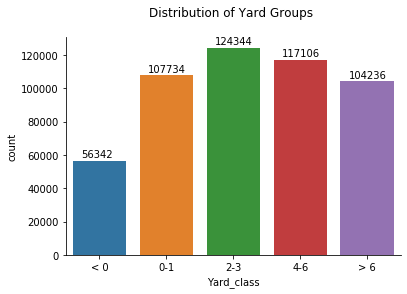

In [3]:
# graph distribution of ranges of yards
plot_group_count(nfl, 'Yard_class')

### Random Forest

In [18]:
# define feature and target variables
X = nfl.drop('Yard_class', axis=1)
y = nfl['Yard_class']

# label encode categorical features
for col in X.columns:
    if X[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))

In [19]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [20]:
rf_v = RandomForestClassifier(random_state=220)
rf_v.fit(X_train, y_train)
rf_v.score(X_train, y_train), rf_v.score(X_test, y_test)

(0.9999926436150257, 0.9967534059811874)

In [7]:
pickle.dump(rf_v, open('Models/rfc_v.sav', 'wb'))

### Catboost

In [5]:
# define feature and target variables
X = nfl.drop('Yard_class', axis=1)
y = nfl['Yard_class']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [6]:
# define categorical columns
cat_feats = []
for col in X.columns:
    if X[col].dtype == 'O':
        cat_feats.append(col)

In [13]:
cb_v = cb.CatBoostClassifier(loss_function='MultiClass',
                             random_state=220)
cb_v.fit(X_train, y_train, cat_features=cat_feats)

0:	learn: 1.6051521	total: 2.21s	remaining: 36m 53s
1:	learn: 1.6012715	total: 4.47s	remaining: 37m 10s
2:	learn: 1.5975804	total: 7.5s	remaining: 41m 32s
3:	learn: 1.5923506	total: 9.86s	remaining: 40m 54s
4:	learn: 1.5889741	total: 11.9s	remaining: 39m 36s
5:	learn: 1.5860294	total: 14s	remaining: 38m 36s
6:	learn: 1.5832893	total: 15.8s	remaining: 37m 18s
7:	learn: 1.5806049	total: 17.8s	remaining: 36m 45s
8:	learn: 1.5781879	total: 19.4s	remaining: 35m 39s
9:	learn: 1.5741373	total: 21.1s	remaining: 34m 45s
10:	learn: 1.5718621	total: 22.7s	remaining: 34m
11:	learn: 1.5697559	total: 24.3s	remaining: 33m 19s
12:	learn: 1.5674832	total: 26s	remaining: 32m 51s
13:	learn: 1.5628347	total: 27.7s	remaining: 32m 32s
14:	learn: 1.5608287	total: 29.8s	remaining: 32m 35s
15:	learn: 1.5589124	total: 31.4s	remaining: 32m 10s
16:	learn: 1.5567293	total: 33.3s	remaining: 32m 2s
17:	learn: 1.5549023	total: 35.1s	remaining: 31m 57s
18:	learn: 1.5532852	total: 37.3s	remaining: 32m 6s
19:	learn: 1.5

153:	learn: 1.3542307	total: 6m 12s	remaining: 34m 8s
154:	learn: 1.3536578	total: 6m 14s	remaining: 34m 2s
155:	learn: 1.3525024	total: 6m 16s	remaining: 33m 59s
156:	learn: 1.3519898	total: 6m 19s	remaining: 33m 55s
157:	learn: 1.3515288	total: 6m 20s	remaining: 33m 49s
158:	learn: 1.3509427	total: 6m 22s	remaining: 33m 45s
159:	learn: 1.3505120	total: 6m 24s	remaining: 33m 40s
160:	learn: 1.3495194	total: 6m 26s	remaining: 33m 35s
161:	learn: 1.3487891	total: 6m 28s	remaining: 33m 30s
162:	learn: 1.3484663	total: 6m 30s	remaining: 33m 27s
163:	learn: 1.3481763	total: 6m 32s	remaining: 33m 22s
164:	learn: 1.3476015	total: 6m 34s	remaining: 33m 17s
165:	learn: 1.3472902	total: 6m 36s	remaining: 33m 14s
166:	learn: 1.3470238	total: 6m 38s	remaining: 33m 9s
167:	learn: 1.3447190	total: 6m 40s	remaining: 33m 2s
168:	learn: 1.3444458	total: 6m 42s	remaining: 32m 58s
169:	learn: 1.3416404	total: 6m 44s	remaining: 32m 52s
170:	learn: 1.3409533	total: 6m 46s	remaining: 32m 48s
171:	learn: 1.

303:	learn: 1.2690008	total: 11m 20s	remaining: 25m 57s
304:	learn: 1.2688265	total: 11m 22s	remaining: 25m 54s
305:	learn: 1.2684596	total: 11m 23s	remaining: 25m 51s
306:	learn: 1.2680720	total: 11m 25s	remaining: 25m 47s
307:	learn: 1.2674197	total: 11m 27s	remaining: 25m 44s
308:	learn: 1.2667862	total: 11m 29s	remaining: 25m 41s
309:	learn: 1.2663645	total: 11m 31s	remaining: 25m 38s
310:	learn: 1.2661569	total: 11m 33s	remaining: 25m 35s
311:	learn: 1.2661070	total: 11m 35s	remaining: 25m 32s
312:	learn: 1.2658161	total: 11m 36s	remaining: 25m 29s
313:	learn: 1.2656692	total: 11m 38s	remaining: 25m 26s
314:	learn: 1.2651602	total: 11m 40s	remaining: 25m 23s
315:	learn: 1.2648278	total: 11m 42s	remaining: 25m 21s
316:	learn: 1.2641359	total: 11m 44s	remaining: 25m 18s
317:	learn: 1.2625034	total: 11m 47s	remaining: 25m 16s
318:	learn: 1.2620862	total: 11m 49s	remaining: 25m 14s
319:	learn: 1.2610983	total: 11m 52s	remaining: 25m 14s
320:	learn: 1.2604325	total: 11m 55s	remaining: 

451:	learn: 1.2168617	total: 15m 35s	remaining: 18m 54s
452:	learn: 1.2165412	total: 15m 37s	remaining: 18m 51s
453:	learn: 1.2162844	total: 15m 38s	remaining: 18m 49s
454:	learn: 1.2161344	total: 15m 40s	remaining: 18m 46s
455:	learn: 1.2158430	total: 15m 42s	remaining: 18m 43s
456:	learn: 1.2153957	total: 15m 43s	remaining: 18m 41s
457:	learn: 1.2152022	total: 15m 45s	remaining: 18m 39s
458:	learn: 1.2151191	total: 15m 47s	remaining: 18m 36s
459:	learn: 1.2149312	total: 15m 49s	remaining: 18m 34s
460:	learn: 1.2146519	total: 15m 50s	remaining: 18m 31s
461:	learn: 1.2143449	total: 15m 52s	remaining: 18m 28s
462:	learn: 1.2141377	total: 15m 54s	remaining: 18m 26s
463:	learn: 1.2138506	total: 15m 55s	remaining: 18m 24s
464:	learn: 1.2136708	total: 15m 57s	remaining: 18m 21s
465:	learn: 1.2135134	total: 15m 59s	remaining: 18m 19s
466:	learn: 1.2130391	total: 16m	remaining: 18m 16s
467:	learn: 1.2128633	total: 16m 2s	remaining: 18m 14s
468:	learn: 1.2126486	total: 16m 4s	remaining: 18m 11

599:	learn: 1.1746080	total: 19m 40s	remaining: 13m 7s
600:	learn: 1.1744586	total: 19m 42s	remaining: 13m 4s
601:	learn: 1.1741665	total: 19m 44s	remaining: 13m 2s
602:	learn: 1.1739438	total: 19m 45s	remaining: 13m
603:	learn: 1.1736474	total: 19m 47s	remaining: 12m 58s
604:	learn: 1.1734077	total: 19m 48s	remaining: 12m 56s
605:	learn: 1.1719870	total: 19m 50s	remaining: 12m 54s
606:	learn: 1.1719189	total: 19m 52s	remaining: 12m 51s
607:	learn: 1.1707603	total: 19m 53s	remaining: 12m 49s
608:	learn: 1.1699300	total: 19m 55s	remaining: 12m 47s
609:	learn: 1.1697375	total: 19m 57s	remaining: 12m 45s
610:	learn: 1.1695993	total: 19m 59s	remaining: 12m 43s
611:	learn: 1.1687997	total: 20m	remaining: 12m 41s
612:	learn: 1.1687227	total: 20m 2s	remaining: 12m 39s
613:	learn: 1.1684996	total: 20m 4s	remaining: 12m 37s
614:	learn: 1.1683310	total: 20m 6s	remaining: 12m 35s
615:	learn: 1.1680088	total: 20m 7s	remaining: 12m 32s
616:	learn: 1.1675263	total: 20m 9s	remaining: 12m 30s
617:	lea

748:	learn: 1.1308139	total: 24m 8s	remaining: 8m 5s
749:	learn: 1.1299455	total: 24m 10s	remaining: 8m 4s
750:	learn: 1.1289269	total: 24m 11s	remaining: 8m 2s
751:	learn: 1.1288418	total: 24m 13s	remaining: 8m
752:	learn: 1.1287688	total: 24m 15s	remaining: 7m 58s
753:	learn: 1.1282977	total: 24m 17s	remaining: 7m 56s
754:	learn: 1.1280594	total: 24m 19s	remaining: 7m 54s
755:	learn: 1.1280096	total: 24m 21s	remaining: 7m 52s
756:	learn: 1.1277843	total: 24m 23s	remaining: 7m 50s
757:	learn: 1.1273800	total: 24m 24s	remaining: 7m 48s
758:	learn: 1.1272861	total: 24m 26s	remaining: 7m 46s
759:	learn: 1.1262919	total: 24m 28s	remaining: 7m 44s
760:	learn: 1.1262498	total: 24m 30s	remaining: 7m 42s
761:	learn: 1.1260927	total: 24m 32s	remaining: 7m 40s
762:	learn: 1.1258156	total: 24m 35s	remaining: 7m 38s
763:	learn: 1.1253668	total: 24m 37s	remaining: 7m 37s
764:	learn: 1.1252774	total: 24m 39s	remaining: 7m 34s
765:	learn: 1.1251340	total: 24m 41s	remaining: 7m 33s
766:	learn: 1.1249

899:	learn: 1.0944235	total: 29m 4s	remaining: 3m 14s
900:	learn: 1.0943538	total: 29m 7s	remaining: 3m 12s
901:	learn: 1.0942892	total: 29m 10s	remaining: 3m 10s
902:	learn: 1.0939664	total: 29m 12s	remaining: 3m 8s
903:	learn: 1.0929942	total: 29m 14s	remaining: 3m 6s
904:	learn: 1.0929260	total: 29m 17s	remaining: 3m 4s
905:	learn: 1.0927927	total: 29m 20s	remaining: 3m 2s
906:	learn: 1.0925770	total: 29m 22s	remaining: 3m
907:	learn: 1.0924264	total: 29m 24s	remaining: 2m 59s
908:	learn: 1.0923009	total: 29m 27s	remaining: 2m 57s
909:	learn: 1.0921890	total: 29m 29s	remaining: 2m 55s
910:	learn: 1.0919550	total: 29m 32s	remaining: 2m 53s
911:	learn: 1.0915937	total: 29m 35s	remaining: 2m 51s
912:	learn: 1.0914029	total: 29m 37s	remaining: 2m 49s
913:	learn: 1.0913016	total: 29m 39s	remaining: 2m 47s
914:	learn: 1.0911378	total: 29m 41s	remaining: 2m 45s
915:	learn: 1.0906352	total: 29m 42s	remaining: 2m 43s
916:	learn: 1.0904404	total: 29m 44s	remaining: 2m 41s
917:	learn: 1.090294

AttributeError: 'CatBoostClassifier' object has no attribute 'roc_auc_score'

In [17]:
pickle.dump(cb_v, open('Models/cb_v.sav', 'wb'))

In [21]:
cb_v = pickle.load(open('Models/cb_v.sav', 'rb'))

print('Train Score:', cb_v.score(X_train, y_train))
print('Test Score:', cb_v.score(X_test, y_test))

Train Score: 0.6865591490133862
Test Score: 0.6932213863250714


### Logistic Regression

In [12]:
# define feature and target variables
X = nfl.drop('Yard_class', axis=1)
y = nfl['Yard_class']

# create dummy variables for categorical features
X = pd.get_dummies(X, drop_first=True)

In [13]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [14]:
# scale data for training and testing
scaler = StandardScaler()

X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

int_cols = []
for cols in nfl.columns:
    if (nfl[cols].dtype != 'O') & (cols != 'Yard_class'):
        int_cols.append(cols)

scale_feats_train = X_train_scale[int_cols]
scale_feats_test = X_test_scale[int_cols]
scale_feats_train = scaler.fit_transform(scale_feats_train.values)
scale_feats_test = scaler.transform(scale_feats_test.values)

X_train_scale[int_cols] = scale_feats_train
X_test_scale[int_cols] = scale_feats_test

In [26]:
log_v = LogisticRegression(solver='saga',
                           multi_class='multinomial',
                           random_state=220)
log_v.fit(X_train_scale, y_train)

pickle.dump(log_v, open('Models/log_v.sav', 'wb'))

In [28]:
log_v = pickle.load(open('Models/log_v.sav', 'rb'))

print('Train Score:', log_v.score(X_train_scale, y_train))
print('Test Score:', log_v.score(X_test_scale, y_test))

Train Score: 0.30582454040984874
Test Score: 0.2845526860416074


## Interpreting the Results

I used the Random Forest Vanilla model, the model with the best accuracy score, to analyze which features most impact the range of yards gained.

In [7]:
# load saved model
rf_v = pickle.load(open('Models/rfc_v.sav', 'rb'))

# train and test scores of the model
print('Train Score:', rf_v.score(X_train, y_train))
print('Test Score:', rf_v.score(X_test, y_test))

Train Score: 0.9999485053051796
Test Score: 0.992025737349563


### Feature Importance

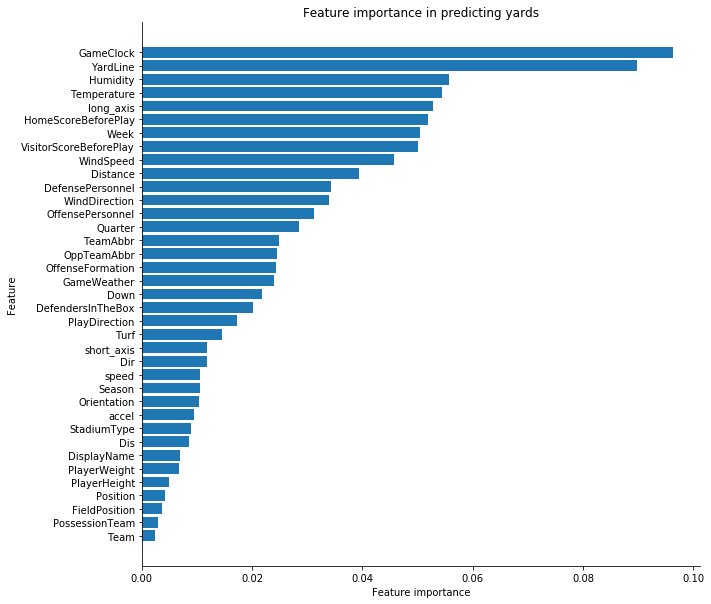

In [21]:
plot_reg_feat_imp(rf_v, X)
sns.despine(left=False, bottom=False)
plt.savefig('Images/rfc_vanilla_feats.png',
            bbox_inches='tight',
            transparent=True)

**Top 10 Features**

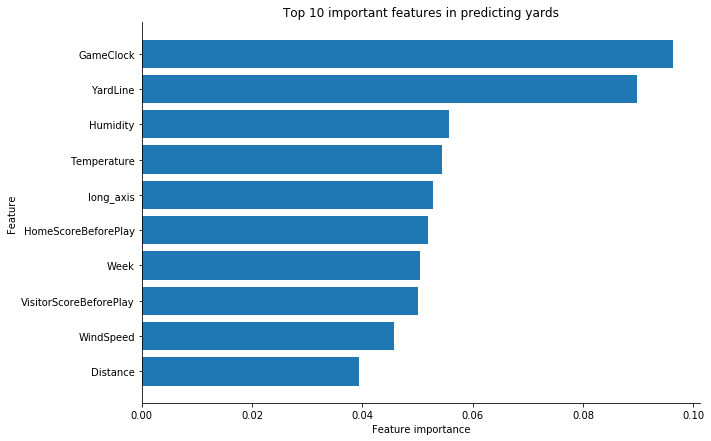

In [22]:
plot_reg_feat_imp(rf_v, X, top10=True)
sns.despine(left=False, bottom=False)
plt.savefig('Images/rfc_top10_feats.png',
            bbox_inches='tight',
            transparent=True)

**Confusion Matrix**

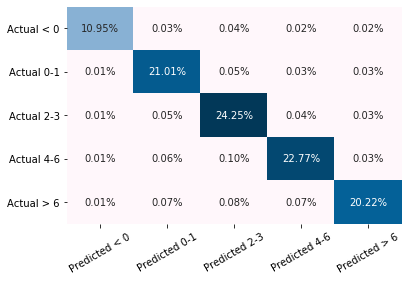

In [11]:
matrix = confusion_matrix(y_test, rf_v.predict(X_test))
matrix = matrix / matrix.astype(np.float).sum()
conf_mat = pd.DataFrame(matrix,
                        index=['Actual < 0', 'Actual 0-1',
                               'Actual 2-3', 'Actual 4-6',
                               'Actual > 6'],
                        columns=['Predicted < 0', 'Predicted 0-1',
                                 'Predicted 2-3', 'Predicted 4-6',
                                 'Predicted > 6'])

sns.heatmap(conf_mat, cmap='PuBu', annot=True,
            cbar=False, fmt='.2%')
plt.xticks(rotation=30)
plt.savefig('Images/conf_mat.png', bbox_inches='tight');

**Precision, Recall, F1 score, and Accuracy in predicting range of yards**

In [12]:
print(classification_report(y_test, rf_v.predict(X_test), digits=4,
                            target_names=['< 0', '0-1', '2-3', '4-6', '> 6']))

              precision    recall  f1-score   support

         < 0     0.9948    0.9908    0.9928     11269
         0-1     0.9902    0.9941    0.9922     21547
         2-3     0.9892    0.9942    0.9917     24869
         4-6     0.9928    0.9912    0.9920     23421
         > 6     0.9949    0.9889    0.9919     20847

    accuracy                         0.9920    101953
   macro avg     0.9924    0.9918    0.9921    101953
weighted avg     0.9920    0.9920    0.9920    101953

